# PSO


In [13]:
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
from matplotlib.animation import FuncAnimation
from sko.PSO import PSO
import numpy as np
from scipy.fft import dct, idct, dctn, idctn
import matplotlib as mpl
# 设置全局字体为 Times New Roman
mpl.rcParams['font.family'] = 'serif'
mpl.rcParams['font.serif'] = ['Times New Roman']
mpl.rcParams['font.weight'] = 'bold'  # 设置字体为粗体

In [14]:
# -*- coding: utf-8 -*-
"""
Nonequispaced DCT/DST via least squares on cosine/sine bases.

- NDCT:  使用 cos(k*pi*x), k=0..K  （偶延拓，适合边界不为 0 的函数）
- NDST:  使用 sin(k*pi*x), k=1..K  （奇延拓，适合两端近似为 0 的函数）

依赖：numpy, matplotlib
"""

import numpy as np
import matplotlib.pyplot as plt
from dataclasses import dataclass

# -------------------------- Bases & Solver --------------------------

def ndct_basis(x, K):
    """
    构造 NDCT 设计矩阵 A，列为 cos(k*pi*x), k=0..K
    x: (m,) 数组，需落在 [0,1]
    返回：A.shape == (m, K+1)
    """
    x = np.asarray(x).reshape(-1)
    ks = np.arange(K + 1)                         # 0..K
    return np.cos(np.pi * np.outer(x, ks))        # m x (K+1)

def lsq_fit(A, y, lam=0.0):
    """
    求解 min ||A c - y||_2^2 + lam ||c||_2^2 （lam>0 为岭回归）
    返回：系数向量 c
    """
    y = np.asarray(y).reshape(-1)
    n = A.shape[1]
    if lam and lam > 0:
        # 稳定的岭回归解： (A^T A + lam I) c = A^T y
        ATA = A.T @ A
        ATy = A.T @ y
        return np.linalg.solve(ATA + lam * np.eye(n), ATy)
    else:
        return np.linalg.lstsq(A, y, rcond=None)[0]

# -------------------------- Models --------------------------

@dataclass
class NDCTModel:
    coeffs: np.ndarray
    K: int
    xmin: float
    xmax: float
    def predict(self, t):
        # 预测时缩放到 [0,1]
        t01, _, _ = to_unit_interval(t, self.xmin, self.xmax)
        return ndct_basis(t01, self.K) @ self.coeffs




def ndct_fit(x, y, K, lam=0.0):
    x01, xmin, xmax = to_unit_interval(x)   # 缩放
    A = ndct_basis(x01, K)
    c = lsq_fit(A, y, lam=lam)
    return NDCTModel(c, K, xmin, xmax)


# -------------------------- Utilities --------------------------

def rmse(a, b):
    a = np.asarray(a); b = np.asarray(b)
    return float(np.sqrt(np.mean((a - b) ** 2)))

def to_unit_interval(x, xmin=None, xmax=None):
    """
    可选：把任意区间的自变量线性缩放到 [0,1]
    返回：x01, xmin, xmax
    """
    x = np.asarray(x)
    if xmin is None: xmin = float(np.min(x))
    if xmax is None: xmax = float(np.max(x))
    x01 = (x - xmin) / (xmax - xmin)
    return x01, xmin, xmax

# -------------------------- Demo --------------------------

# 1-D Fourier Series

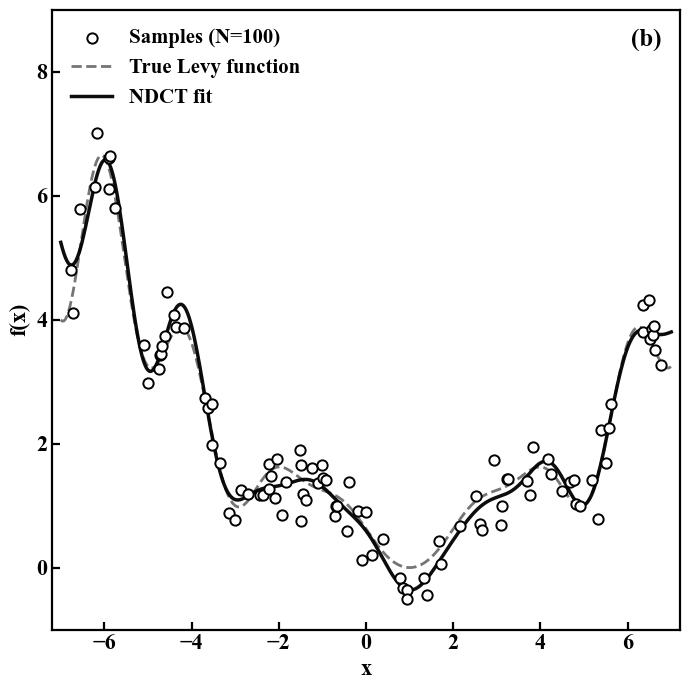

In [15]:
N = 100
L_interval = 7.0   # Levy 常用定义域 [-10, 10]
np.random.seed(33)
x1 = np.sort((np.random.rand(N) * 2 - 1) * L_interval)   # 非均匀采样, 映射到 [-10, 10]
def levy(x):
    w = 1 + (x - 1) / 4
    return np.sin(np.pi * w)**2 + (w - 1)**2 * (1 + np.sin(2 * np.pi * w)**2)
# 加高斯噪声
noise_level = 0.3
f = levy(x1) + np.random.normal(0, noise_level, size=N)

# ---------- Step 2: 使用 NDCT 来拟合 ----------
t_dense = np.linspace(-L_interval, L_interval, 400)   # 高分辨率网格
K_dct = 18
model_dct = ndct_fit(x1, f, K=K_dct, lam=1e-6)
y_hat1 = model_dct.predict(t_dense)

# ---------- Step 3: 可视化 ----------
fig, ax = plt.subplots(figsize=(7, 7))
# NDCT fit: 黑色实线
ax.plot(t_dense, y_hat1, label="NDCT fit",
        lw=2.5, color="black", linestyle="-", alpha=0.95, zorder=2)
# Ground truth: 浅灰虚线
ax.plot(t_dense, levy(t_dense), label="True Levy function",
        lw=2.0, color="0.4", linestyle="--", alpha=0.9, zorder=1)

# Samples: 空心深蓝圆点
ax.scatter(x1, f, s=55, facecolors="white", edgecolors="black",
           linewidths=1.4, marker='o', label=f"Samples (N={N})", zorder=3)





# 坐标轴设置
ax.set_xlabel('x', fontsize=16, fontweight='bold', family='Times New Roman')
ax.set_ylabel('f(x)', fontsize=16, fontweight='bold', family='Times New Roman')
ax.set_xlim(-7.2, L_interval + 0.2)
ax.set_ylim(-1, 9)
ax.tick_params(axis='both', direction='in', which='both', 
               labelsize=16, width=1.6, length=6)
for spine in ax.spines.values():
    spine.set_linewidth(1.6)

# 图例（放在空白区，字体稍小）
handles, labels = ax.get_legend_handles_labels()
ax.legend(handles[::-1], labels[::-1], 
          loc='upper left', fontsize=15, frameon=False)

# Panel 标号
ax.text(0.97, 0.97, "(b)", transform=ax.transAxes,
        fontsize=18, fontweight="bold", ha="right", va="top")

plt.tight_layout()
plt.show()

# old PSO

In [16]:
max_iter = 151  # 设置最大迭代次数
# 定义PSO的目标函数
def ndct_objective(x_array):
    # PSO 的位置变量 x_array 是数组
    x = x_array[0]  
    
    # 用训练好的 NDCT 模型预测
    y_pred = model_dct.predict(np.array([x]))[0]
    
    # PSO 是最小化器，所以返回 -y_pred
    return y_pred

# 初始化 PSO
pso = PSO(func=ndct_objective, n_dim=1, pop=20, max_iter=max_iter,
          lb=[-7], ub=[7], w=0.8, c1=1.2, c2=1)
pso.record_mode = True
# 设置收敛阈值 precision=1e-6，连续 15 代差异 < 阈值就停止
best_x, best_y = pso.run(precision=1e-6, N=30)

print("Best solution:", best_x)
print("Best value:", best_y)
print("实际迭代次数:", len(pso.gbest_y_hist))



Best solution: [1.0171226]
Best value: [-0.36086005]
实际迭代次数: 151


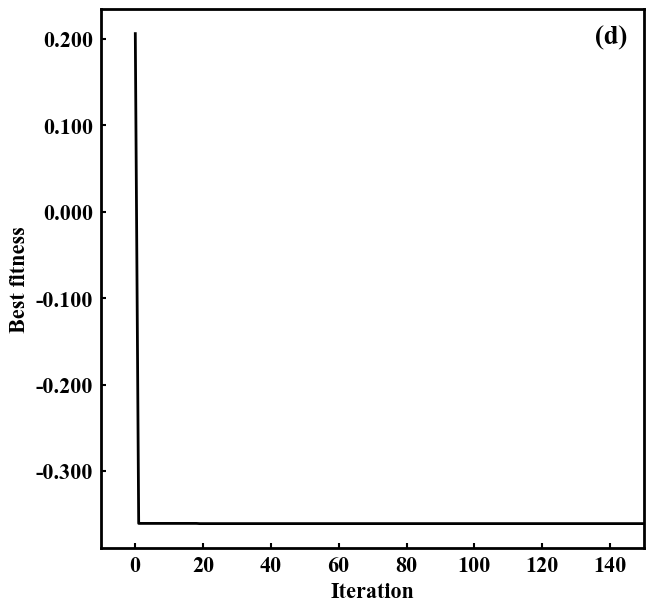

In [19]:
from matplotlib.ticker import FormatStrFormatter, MultipleLocator
# gbest_y_hist 里记录了每一代的最优 fitness
y = -np.array([float(-v) for v in pso.gbest_y_hist])

# ---------- Step 3: 可视化 ----------
fig, ax = plt.subplots(figsize=(7, 7))

# 黑色拟合线（底层）

# 原始采样点（中层）
ax.plot(y, color='black', linewidth=2)


# ---------- 图形美化 ----------
ax.set_xlabel('Iteration', fontsize=16, fontweight='bold')
ax.set_ylabel('Best fitness', fontsize=16, fontweight='bold')
ax.set_xlim(-10, 150)
ax.set_ylim(auto=True)
ax.yaxis.set_major_formatter(FormatStrFormatter('%.3f'))
ax.tick_params(axis='both', direction='in', which='both', labelsize=16, width=1.5,pad=6)
for spine in ax.spines.values():
    spine.set_linewidth(2)


# 在右上角加上 (f)
ax.text(
    0.97, 0.97, "(d)",
    transform=ax.transAxes,
    fontsize=19, fontweight="bold",
    ha="right", va="top"
)

plt.show()

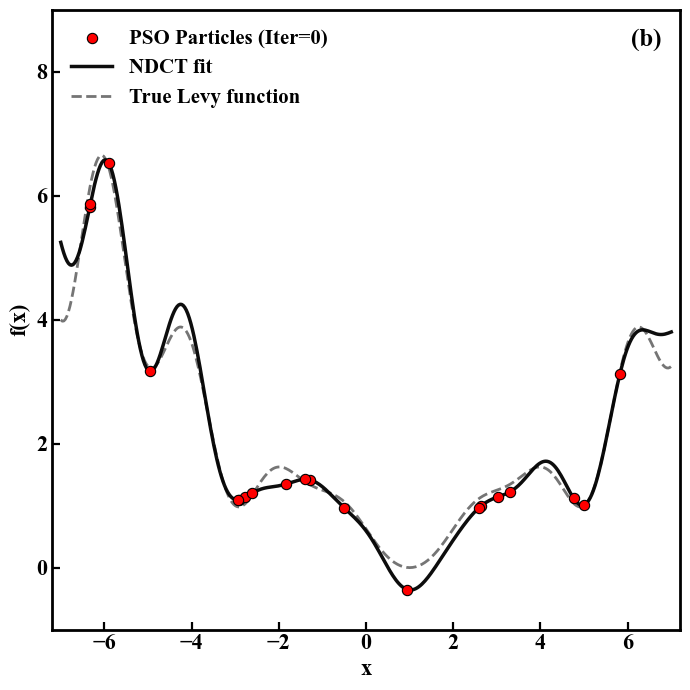

In [18]:
import numpy as np
import matplotlib.pyplot as plt

# ---------------------- Levy Function (1D) ----------------------
def levy(x):
    w = 1 + (x - 1) / 4
    return np.sin(np.pi * w)**2 + (w - 1)**2 * (1 + np.sin(2 * np.pi * w)**2)

# ---------------------- Main Demo ----------------------
if __name__ == "__main__":
    np.random.seed(33)

    # ---------- Step 1: 生成不规则采样点 ----------
    N = 100
    L_interval = 7.0   # Levy 常用定义域 [-10, 10]
    x1 = np.sort((np.random.rand(N) * 2 - 1) * L_interval)  # 非均匀采样

    # 加高斯噪声
    noise_level = 0.3
    f = levy(x1) + np.random.normal(0, noise_level, size=N)

    # ---------- Step 2: 使用 NDCT 来拟合 ----------
    t_dense = np.linspace(-L_interval, L_interval, 400)   # 高分辨率网格
    K_dct = 18
    model_dct = ndct_fit(x1, f, K=K_dct, lam=1e-6)
    y_hat1 = model_dct.predict(t_dense)

    # ---------- Step 3: 可视化 ----------
    fig, ax = plt.subplots(figsize=(7, 7))

    # (1) Ground truth: 浅灰虚线
    ax.plot(
        t_dense, levy(t_dense), label="True Levy function",
        lw=2.0, color="0.4", linestyle="--", alpha=0.9, zorder=1
    )

    # (2) NDCT 拟合: 黑色实线
    ax.plot(
        t_dense, y_hat1, label="NDCT fit",
        lw=2.5, color="black", linestyle="-", alpha=0.95, zorder=2
    )
    # (4) 加入 PSO 粒子点: 红色实心
    target_iter = 0  # 指定迭代次数
    particle_positions = pso.record_value['X'][target_iter].ravel()
    particle_values = model_dct.predict(particle_positions)
    ax.scatter(
        particle_positions, particle_values,
        c="red", s=55, marker="o", edgecolors="black", linewidths=0.8,
        label=f"PSO Particles (Iter={target_iter})",
        zorder=4
    )

    # ---------- 坐标轴美化 ----------
    ax.set_xlabel('x', fontsize=16, fontweight='bold', family='Times New Roman')
    ax.set_ylabel('f(x)', fontsize=16, fontweight='bold', family='Times New Roman')
    ax.set_xlim(-L_interval - 0.2, L_interval + 0.2)
    ax.set_ylim(-1, 9)
    ax.tick_params(axis='both', direction='in', which='both',
                   labelsize=16, width=1.6, length=6)
    for spine in ax.spines.values():
        spine.set_linewidth(2)

    # ---------- 图例（倒序，让红点最上层） ----------
    handles, labels = ax.get_legend_handles_labels()
    ax.legend(
        handles[::-1], labels[::-1],
        loc='upper left', fontsize=15, frameon=False
    )

    # ---------- Panel 标号 ----------
    ax.text(
        0.97, 0.97, "(b)", transform=ax.transAxes,
        fontsize=18, fontweight="bold", ha="right", va="top"
    )

    plt.tight_layout()
    plt.show()
